In [2]:
# Importing packages
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping

# Importing Pauli matrices
from pauli_matrices.pauli_matrices import I, X, Y, Z

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from Bell_operator.Bell_operator import get_Bell_terms
from Bell_operator.coefficients import get_coefficients
from classical_optimization.classical_optimization import classical_optimization
from correlation_matrix.correlation_matrix import get_correlation_matrix

# Defining saving directory
save_dir = '../data/figures/'


In [3]:
def calc_classical_bound(theta, H, N, m, basis, extra_Z_gate):

    # Obtaining the general correlation matrix
    M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=extra_Z_gate)

    # Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
    Bell_terms, indices = get_Bell_terms(M, N, m)

    # Calculating the coefficients
    coeffs = get_coefficients(Bell_terms, H, N)

    # Calculating and returning the classical bound 
    return classical_optimization(coeffs, indices, N, m)


In [4]:
# Defining the number of qubits
N = 2

# Defining the Hamiltonian
H = np.sqrt(2)*(np.kron(Z, Z) + np.kron(X, X))

# Calculating the eigenvalues and eigenstates
eig_vals, eig_vecs = np.linalg.eigh(H)

# extracting the ground state energy and the respective eigenstate
psi_G = eig_vecs[:,0]
psi_G_dagger = np.conjugate(np.transpose(psi_G))

In [7]:
# Defining number of measurements and the angle between the two parties
m = 2
theta = np.pi/4

# Obtaining the general correlation matrix
M = get_correlation_matrix(theta, N, m, basis='XZ', extra_Z_gate=False)

# Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
Bell_terms, indices = get_Bell_terms(M, N, m)

# Calculating the coefficients
coeffs = get_coefficients(Bell_terms, H, N)

# Calculating the classical bound
beta_C = classical_optimization(coeffs, indices, N, m)
beta_C


-2.000000000000001

In [8]:
# Initializing the Bell operator
B = np.zeros((2**N, 2**N), dtype='complex128')

# Adding terms to the Bell operator
for j in range(len(coeffs)):
    B += coeffs[j]*Bell_terms[j]

# Calculating the difference between the Bell operator and the Hamiltonian
# print(np.sum(np.abs(B-H), axis=(0,1)))

# Calculting the quantum value
beta_Q = np.matmul(psi_G_dagger, np.matmul(B, psi_G))
np.real(beta_Q)

-2.8284271247461894

In [11]:
# Defining the number of measurements
m = 7

# Defining angles
angles = np.linspace(0, 2*np.pi, 100)

# Initializing classical bound
beta_C = []

# Calculating classical bounds
for theta in tqdm(angles):

    # Obtaining the classical bound with the recursive algorithm
    beta_C.append( calc_classical_bound(theta, H, N, m, 'XZ', False) )


100%|██████████| 100/100 [04:27<00:00,  2.68s/it]


[Text(0.0, 0, '0'),
 Text(1.5707963267948966, 0, '$\\frac{\\pi}{2}$'),
 Text(3.141592653589793, 0, '$\\pi$'),
 Text(4.71238898038469, 0, '$\\frac{3 \\pi}{2}$'),
 Text(6.283185307179586, 0, '$2\\pi$')]

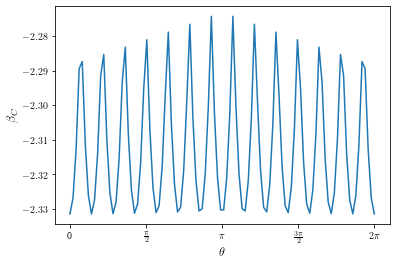

In [12]:
fig, ax = plt.subplots()
ax.plot(angles, beta_C)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\beta_C$')
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3 \pi}{2}$', r'$2\pi$']);
fig.savefig(save_dir + 'classical_bound_toy_model_varying_basis.png', dpi = 300, bbox_inches='tight');

In [20]:
# Defining the number of measurements
m = 2

# Defining angles
init_guess = np.pi/3

# Defining bounds for the variables
bnds = ((0, 2*np.pi),)

# Defining arguments
basis = 'XZ'
extra_Z_gate = False
args = (H, N, m, basis, extra_Z_gate)

# Defining minimization options
options = {
        'maxiter'  : 2000,
        'gtol'     : 1e-12
}

# Creating the basinhopping algorithm
minimizer_kwargs = {
                'method'  : "L-BFGS-B",
                'args'    : args,
                'jac'     : '2-point',
                'bounds'  : bnds,
                'options' : options
}

res = basinhopping(calc_classical_bound, init_guess,
                minimizer_kwargs = minimizer_kwargs,
                niter = 10,
                disp = False
)



In [21]:
res

                        fun: -2.828427124746193
 lowest_optimization_result:       fun: -2.828427124746193
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.69182437e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([1.57079631])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1
                       nfev: 182
                        nit: 10
                       njev: 91
                          x: array([1.57079631])